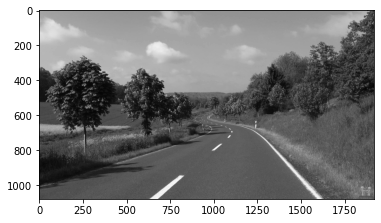

In [11]:
from PIL import Image
import imageio
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

COLOR_CLASSES = [0, 127, 255]
CLASSES = [0, 1, 2]
four_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
eight_neighbors_related_positions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]

path = '../data/test2.jpg'
image = imageio.imread(path, as_gray=True)
plt.imshow(image, label="gray image", cmap='gray')

In [93]:
def get_class_labels(data: [], mode='gray'):
    labels = np.zeros((len(data), len(data[0])))
    for row in range(len(data)):
        for col in range(len(data[0])):
            value = data[row][col]
            if mode == 'rgb':
                value = value[0] * 0.2125 + value[1] * 0.7154 + value[2] * 0.0721
            if value < 85:
                label = 0
            elif value < 170:
                label = 1
            else:
                label = 2
            labels[row][col] = label

    return labels


def get_class_information(data: [], labels: []):
    data_info = {}
    class_info = {}

    for c in CLASSES:
        data_info[c] = {
            'data': [],
            'mean': 0,
            'var': 0,
            'probability': 0
        }

        class_info[c] = {
            'mean': 0,
            'var': 0,
            'probability': 0
        }

    for c in CLASSES:
        for row in range(len(data)):
            for col in range(len(data[0])):
                if labels[row][col] == c:
                    data_info.get(c).get('data').append(data[row][col])

    data_count = len(data) * len(data[0])
    for c in CLASSES:
        class_info[c] = {
            'mean': np.mean(data_info.get(c).get('data')),
            'var': np.var(data_info.get(c).get('data')),
            'probability': len(data_info.get(c).get('data')) / data_count
        }
    return class_info


true_labels = get_class_labels(data=image)


# Part C
class SimulatedAnnealing:

    def __init__(self, labels, image, class_info, neighbors_related_positions, iterations=1000, temperature=10000,
                 betha=1, schedule_coefficient=1, schedule_steps=1000, mode='gray'):
        self.labels = labels
        self.image = image
        self.class_info = class_info
        self.iterations = iterations
        self.temperature = temperature
        self.neighbors_related_positions = neighbors_related_positions
        self.betha = betha
        self.schedule_coefficient = schedule_coefficient
        self.schedule_steps = schedule_steps
        self.mode = mode

    def move(self, labels):
        new_classes = np.copy(CLASSES).tolist()

        random_index_x, random_index_y = random.randint(0, len(labels) - 1), random.randint(0, len(labels[0]) - 1)
        random_label = random.randint(0, len(new_classes) - 1)

        while labels[random_index_x][random_index_y] == random_label:
            random_label = random.randint(0, len(new_classes) - 1)
        return random_label, random_index_x, random_index_y

    def energy(self, new_labels, label, row, col):
        energy = 0.0
        class_mean = self.class_info[int(label)].get('mean')
        class_var = self.class_info[int(label)].get('var')
        energy += np.log(np.sqrt(2 * np.pi * class_var)) + ((label * 127 - class_mean) ** 2) / (2 * (class_var ** 2))
        neighbors_indexes = self.get_neighbours_indexes(row, col)
        for neighbor in neighbors_indexes:
            if neighbor[0] < len(new_labels) and neighbor[1] < len(new_labels[0]):
                energy += self.betha * self.are_different(label, new_labels[neighbor[0]][neighbor[1]])
        return energy

    
    def anneal(self, temperature_function):
        new_labels = np.copy(self.labels)
        temperature = self.temperature
        for i in range(self.iterations):
            random_label, random_row, random_col = self.move(new_labels)
            current_energy = self.energy(new_labels, new_labels[random_row][random_col], random_row, random_col)
            new_energy = self.energy(new_labels, random_label, random_row, random_col)
            delta_U = new_energy - current_energy
            random_uniform = random.uniform(0, 1)
            if self.is_eligible_to_update(delta_U, temperature, random_uniform):
                new_labels[random_row][random_col] = random_label
            temperature = temperature_function(temperature)
        return new_labels

    def get_neighbours_indexes(self, row, col):
        indexes = []
        for index in self.neighbors_related_positions:
            indexes.append((row + index[0], col + index[1]))

        return indexes

    @staticmethod
    def is_eligible_to_update(delta_U, temperature, random_uniform):
        return delta_U <= 0 or (delta_U > 0 and random_uniform < np.exp(-delta_U / temperature))

    @staticmethod
    def distance(a, b):
        return np.sqrt(np.sum(np.exp(a - b, 2)))

    @staticmethod
    def are_different(x, y):
        if x == y:
            return -1
        return 1

    def exponential_schedule(self, temperature):
        return temperature * 0.99

    def logarithmic_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * np.log(1 + self.schedule_steps))

    def linear_multiplicative_cooling_schedule(self, temperature):
        return temperature / (1 + self.schedule_coefficient * self.schedule_steps)


def plot_before_after(before, after):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title('Real image')
    ax1.imshow(before, cmap='gray')

    ax2.set_title('Simulated Annealing')
    ax2.imshow(after, cmap='gray')

    plt.show()


## Part A

In [16]:
def compare_nb_and_sa(betha=0.1, iterations=1000000):
    class_info = get_class_information(image, true_labels)
    simulated_annealer = SimulatedAnnealing(labels=true_labels, image=image, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=iterations,
                                            betha=betha)

    optimized_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
    plot_before_after(image, optimized_labels)

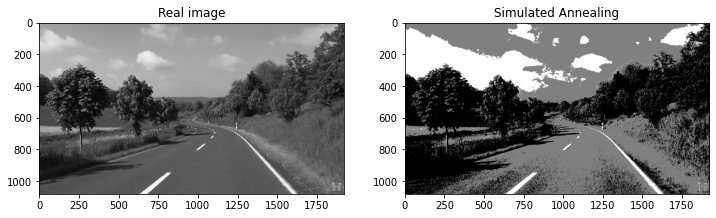

In [17]:
compare_nb_and_sa()

In [20]:
from skimage.color import rgb2hsv

def plot_before_after(before, after, before_label, after_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title(before_label)
    ax1.imshow(before)

    ax2.set_title(after_label)
    ax2.imshow(after)

    plt.show()

rgb_image = imageio.imread(path)

hsv_image = rgb2hsv(rgb_image)
hue_image = hsv_image[:, :, 0]

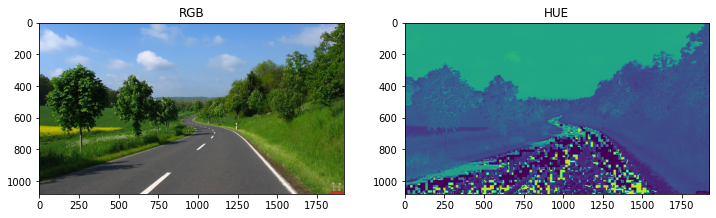

In [21]:
plot_before_after(rgb_image, hue_image, 'RGB', 'HUE')

In [27]:
def plot_before_after(before, after, before_label, after_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

    ax1.set_title(before_label)
    ax1.imshow(before, cmap='gray')

    ax2.set_title(after_label)
    ax2.imshow(after, cmap='gray')

    plt.show()

In [38]:
def compare_hue_and_gray(hue_image):
    hue_labels = get_class_labels(data=hue_image*256)
    class_info = get_class_information(image, true_labels)
    simulated_annealer = SimulatedAnnealing(labels=hue_labels, image=hue_image*256, class_info=class_info,
                                            neighbors_related_positions=four_neighbors_related_positions,
                                            iterations=100000,
                                            betha=100)

    hue_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
    plot_before_after(hue_image, hue_labels, 'HUE', 'SA HUE')

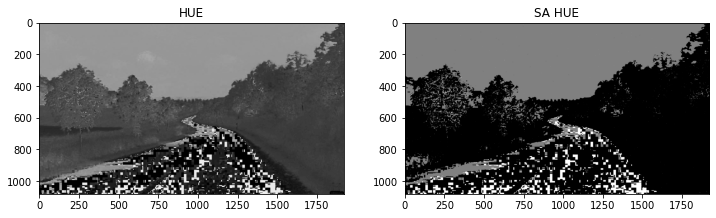

In [39]:
compare_hue_and_gray(hue_image)

## Part B

In [53]:
rgb_image = imageio.imread(path)
rgb_labels = get_class_labels(data=rgb_image, mode='rgb')
class_info = get_class_information(rgb_image, rgb_labels)

In [94]:
def get_rgb_class_labels(data: []):
    labels = np.zeros((len(data), len(data[0])))
    for row in range(len(data)):
        for col in range(len(data[0])):
            value = data[row][col]
            if value[2] > 200:
                label = 1
            elif value[2] < 70:
                label = 2
            else:
                label = 0
            labels[row][col] = label

    return labels


rgb_image = imageio.imread(path)
rgb_labels = get_rgb_class_labels(data=rgb_image)
class_info = get_class_information(rgb_image, rgb_labels)

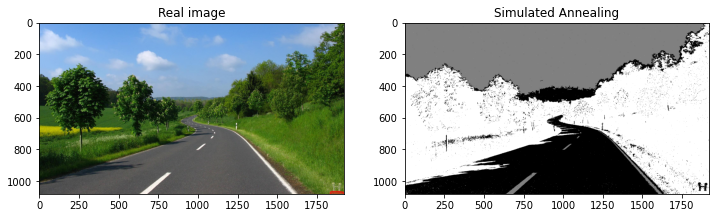

In [96]:
simulated_annealer = SimulatedAnnealing(labels=rgb_labels, image=rgb_image, class_info=class_info,
                                        neighbors_related_positions=eight_neighbors_related_positions,
                                        iterations=100000,
                                        betha=0.1, mode='rgb')

optimized_labels = simulated_annealer.anneal(simulated_annealer.exponential_schedule)
plot_before_after(rgb_image, optimized_labels)